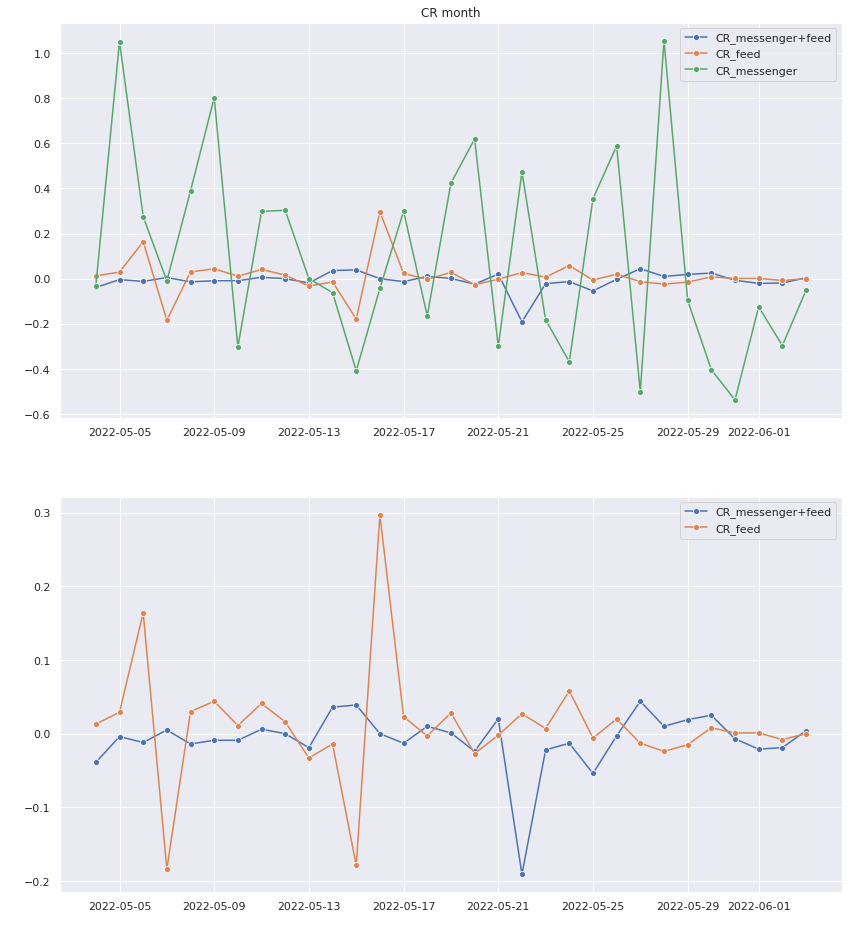

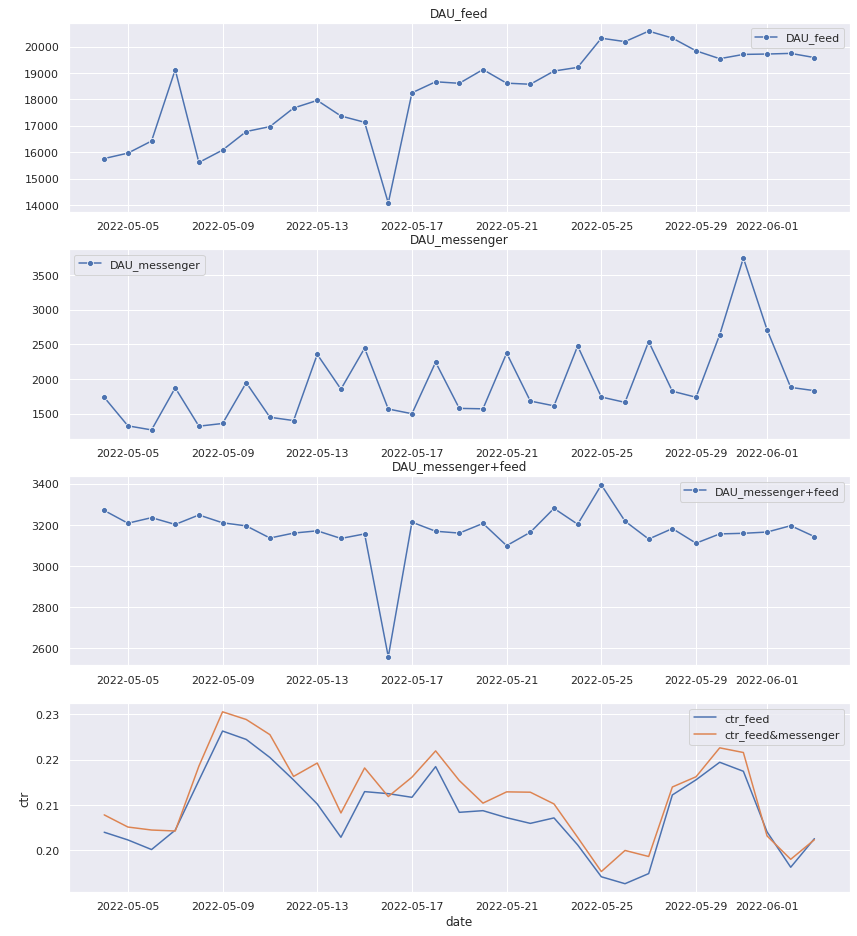

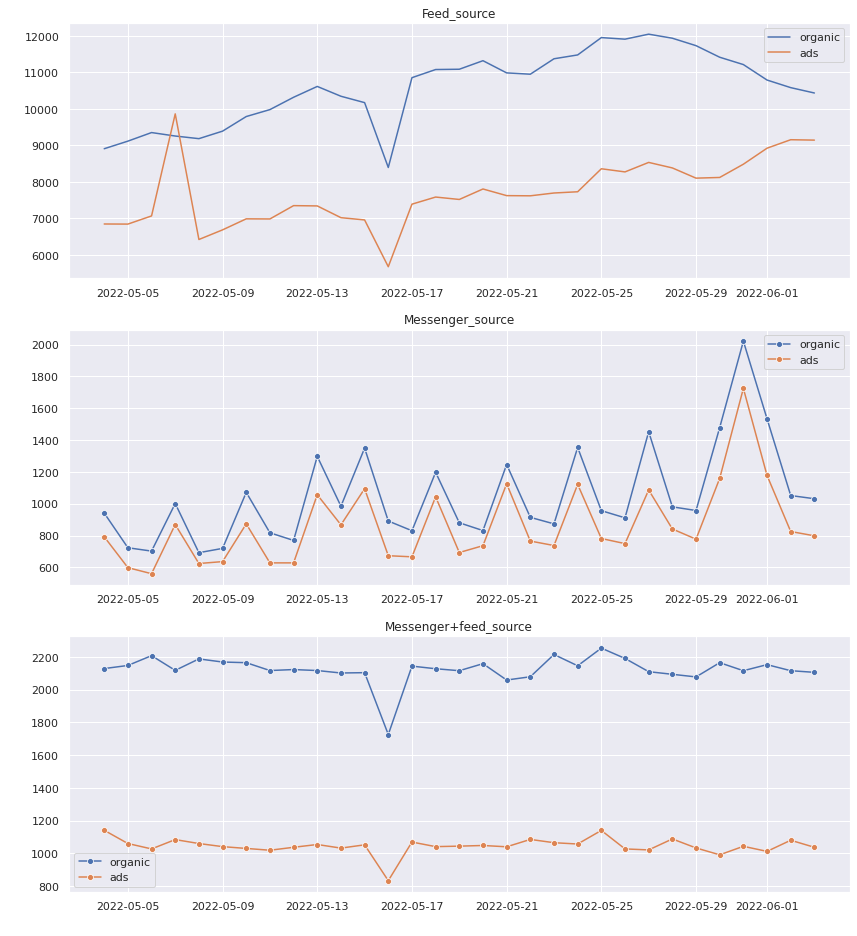

In [123]:
import telegram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from read_db.CH import Getch

sns.set(font_scale=1)

def union_report(chat=None):
    chat_id = chat or 491009072
    bot = telegram.Bot(token='5332579519:AAFPJ9lJrVM32xiSwWfOT_U7f8ESsOd88Vk')
    
    feed = Getch('''SELECT 
            toStartOfDay(toDateTime(time)) as date,
            count(DISTINCT user_id) as DAU,
            countIf(DISTINCT user_id, source='organic') as organic,
            countIf(DISTINCT user_id, source='ads') as ads,
            countIf(user_id, action='like') / countIf(user_id, action='view') as ctr
        FROM simulator_20220520.feed_actions 
        where toDate(time) > yesterday() - interval 1 month and toDate(time) < today()
        GROUP BY date
        ORDER BY date desc''').df
    
    messenger = Getch('''SELECT 
            toStartOfDay(toDateTime(time)) as date,
            count(DISTINCT user_id) as DAU,
            countIf(DISTINCT user_id, source='organic') as organic,
            countIf(DISTINCT user_id, source='ads') as ads
        FROM simulator_20220520.message_actions 
        where toDate(time) > yesterday() - interval 1 month and toDate(time) < today()
        group by date
        ''').df
    
    mf = Getch('''SELECT 
                toStartOfDay(toDateTime(time)) as date,
                count(DISTINCT user_id) as DAU,
                countIf(DISTINCT user_id, source='organic') as organic,
                countIf(DISTINCT user_id, source='ads') as ads,
                countIf(user_id, action='like') / countIf(user_id, action='view') as ctr
            FROM 
                (SELECT user_id, time, os, source, action
                FROM simulator_20220520.feed_actions
                where toDate(time) > yesterday() - interval 1 month and toDate(time) < today()) as f
                JOIN 
                (SELECT user_id FROM simulator_20220520.message_actions
                where toDate(time) > yesterday() - interval 1 month and toDate(time) < today()) as m
                using user_id
                group by date
                ''').df
    
    def col(df):
        df['DAU_lag'] = df['DAU'].shift()
        df['CR'] = round(((df['DAU_lag'] - df['DAU'])/ df['DAU']),3).fillna(0)
        return df

    feed = col(feed)
    messenger = col(messenger)
    mf = col(mf)
    
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))
    sns.lineplot(ax=axes[0], x='date', y='CR', data=mf, label='CR_messenger+feed',marker= 'o', markersize=6).set(title='CR month', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[0],x='date', y='CR', data=feed, label='CR_feed',marker= 'o', markersize=6)
    sns.lineplot(ax=axes[0],x='date', y='CR', data=messenger, label='CR_messenger',marker= 'o', markersize=6)
    sns.lineplot(ax=axes[1], x='date', y='CR', data=mf, label='CR_messenger+feed',marker= 'o', markersize=6).set(xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[1], x='date', y='CR', data=feed, label='CR_feed',marker= 'o', markersize=6)
    
    plot_object = io.BytesIO()  
    plt.savefig(plot_object, dpi=150)     
    plot_object.name = 'CR_report.png' 
    plot_object.seek(0) 
    plt.close
    bot.sendPhoto(chat_id=chat_id, photo=plot_object, caption='Отток пользователей в процентах')
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 16))
    sns.lineplot(ax=axes[0],x='date', y='DAU', data=feed, label='DAU_feed',marker= 'o', markersize=6).set(title='DAU_feed', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[1],x='date', y='DAU', data=messenger, label='DAU_messenger',marker= 'o', markersize=6).set(title='DAU_messenger', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[2],x='date', y='DAU', data=mf, label='DAU_messenger+feed',marker= 'o', markersize=6).set(title='DAU_messenger+feed', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[3],x='date', y='ctr', data=feed, label='ctr_feed')
    sns.lineplot(ax=axes[3],x='date', y='ctr', data=mf, label='ctr_feed&messenger')
    
    plot_object_DAU = io.BytesIO()  
    plt.savefig(plot_object_DAU, dpi=120)     
    plot_object_DAU.name = 'DAU_report.png' 
    plot_object_DAU.seek(0) 
    plt.close
    bot.sendPhoto(chat_id=chat_id, photo=plot_object_DAU,  caption='Динамика по уникальныи пользователям + CTR')
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 16))
    sns.lineplot(ax=axes[1],x='date', y='organic', data=messenger, label='organic',marker= 'o', markersize=6).set(title='Messenger_source', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[1],x='date', y='ads', data=messenger, label='ads',marker= 'o', markersize=6)
    sns.lineplot(ax=axes[0],x='date', y='organic', data=feed, label='organic').set(title='Feed_source', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[0],x='date', y='ads', data=feed, label='ads')
    sns.lineplot(ax=axes[2],x='date', y='organic', data=mf, label='organic',marker= 'o', markersize=6).set(title='Messenger+feed_source', xlabel=' ', ylabel=' ')
    sns.lineplot(ax=axes[2],x='date', y='ads', data=mf, label='ads',marker= 'o', markersize=6)
    
    plot_object_source = io.BytesIO()  
    plt.savefig(plot_object_source, dpi=320)     
    plot_object_source.name = 'source_report.png' 
    plot_object_source.seek(0) 
    plt.close
    bot.sendPhoto(chat_id=chat_id, photo=plot_object_source, caption='Динамика по источнику трафика')
    
    mf.columns=[mf.columns[i] +'_mf' for i in range(len(mf.columns))]
    messenger.columns=[messenger.columns[i] +'_messenger' for i in range(len(messenger.columns))]
    feed.columns=[feed.columns[i] +'_feed' for i in range(len(feed.columns))]
   
    df = pd.merge(feed, messenger, left_on='date_feed', right_on='date_messenger')
    df = pd.merge(df, mf, left_on='date_feed', right_on='date_mf')
    df = df[['date_feed','DAU_feed','CR_feed','DAU_messenger','CR_messenger', 'DAU_mf', 'CR_mf','ctr_feed','ctr_mf']].rename(columns={"date_feed": "date"})
    
    
    file_object = io.StringIO()
    df.to_csv(file_object)
    file_object.seek(0)
    file_object.name = 'report.csv'
    bot.sendDocument(chat_id=chat_id, document=file_object, caption='Отчет за месяц в виде таблицы')
    
    
try:
    union_report()
except Exception as e:
    print(e)